# Importing Neccessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, accuracy_score
from keras.preprocessing import image
from skimage import io, img_as_float

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary
from torchviz import make_dot

import matplotlib.pyplot as plt

import time
import os

np.random.seed(0)
torch.manual_seed(0)

# Accuracy Functions

In [2]:
def atleastOneMatch(y_true, y_pred):
    y_pred=np.array(y_pred)
    total_count=len(y_true)
    total_match=0
    for i in range(0, len(y_true)):
        if(np.any(y_true[i][y_pred[i]==1])):
            total_match+=1
    return total_match/total_count
            
def allMatch(y_true, y_pred):
    y_pred=np.array(y_pred)
    total_count=len(y_true)
    total_match=0
    for i in range(y_true.shape[0]):
        if(np.all(y_pred[i][y_true[i]==1] == 1)):
            total_match+=1
    return total_match/total_count

def accuracy_score(y_true, y_pred):
    y_pred = np.concatenate(tuple(y_pred))
    y_true = np.concatenate(tuple([[t for t in y] for y in y_true])).reshape(y_pred.shape)
    return (y_true == y_pred).sum() / float(len(y_true))

# Reading the Dataset

In [3]:
df = pd.read_csv('/kaggle/input/poster-archive/Multi_Label_dataset/train.csv')
dataset = df.head(1000)

In [4]:
dataset.head()

,Id,Genre,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,N/A,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Thriller,War,Western
0,tt0086425,"['Comedy', 'Drama']",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,tt0085549,"['Drama', 'Romance', 'Music']",0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
2,tt0086465,['Comedy'],0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0086567,"['Sci-Fi', 'Thriller']",0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,tt0086034,"['Action', 'Adventure', 'Thriller']",1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Converting the Images into Numpy array

In [5]:
width = 400
height = 300
X = []
for i in tqdm(range(dataset.shape[0])):
  path = '/kaggle/input/poster-archive/Multi_Label_dataset/Images/'+dataset['Id'][i]+'.jpg'
  img = image.load_img(path,target_size=(width,height,3))
  img = image.img_to_array(img)
  img = img/255.0
  X.append(img)

X = np.array(X)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
y = dataset.drop(['Id','Genre'],axis=1)
y = y.to_numpy()

# Spliting Dataset into Train and Validation

In [7]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1, random_state = 42)

# Setting up Device

In [8]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# Baseline Algorithm

In [9]:
#Just guess at random
N=len(X_train)
y_pred=np.zeros((N,len(y_train[0])))
np.random.seed(23)
for i in range(N):
    x=np.random.randint(0,len(y_train[0]),size=2) #make any 2 genres true
    y_pred[i][x]=1
    
#get accuracy
print(f"Aleast one correct: {atleastOneMatch(y_train, y_pred)*100}%\nAll correct: {allMatch(y_train,y_pred)*100}%")

Aleast one correct: 16.77777777777778%
All correct: 1.4444444444444444%


# Defining the KNN Classifier

In [10]:
def compute_distances_no_loops(x_train, x_test):
    
  num_train = x_train.shape[0]
  num_test = x_test.shape[0]
  dists = x_train.new_zeros(num_test, num_train)

  for i in range(num_test):
    for j in range(num_train):
        dists[i][j] = -torch.sum(torch.abs(x_test[i]-x_train[j]))
        
  return dists

def predict_labels(dists, y_train, k=2):
    
  num_test, num_train = dists.shape
  y_pred = torch.zeros(num_test, y_train.shape[1], dtype=torch.int64)
    
  for i in range(num_test):
    indices = torch.argsort(dists[i])
  
    final_ind = []
    
    for j in range(len(indices)):
        if indices[j]<k:
            final_ind.append(j)
    for ind in final_ind:
        y_pred[i] = torch.add(y_pred[i], y_train[ind])
#     top3 = torch.topk(y_pred[i],3).indices
#     for t3 in top3:
#         if y_pred[i][t3] > 0:
#             y_pred[i][t3] = k+1
    
    y_pred[i][y_pred[i] < k/2] = 0
    y_pred[i][y_pred[i] >=k/2 ] = 1
    
  return y_pred

class KnnClassifier:
  def __init__(self, x_train, y_train):
    self.x_train = x_train.contiguous()
    self.y_train = y_train.contiguous()
  
  def predict(self, x_test, k=2):
    dists = compute_distances_no_loops(self.x_train, x_test.contiguous())
    y_test_pred = predict_labels(dists, self.y_train, k=k)
    return y_test_pred

# Predicting Labels using KNN Classifier

In [11]:
classifier = KnnClassifier(Variable(torch.tensor(X_train)).transpose(2,3).transpose(1,2).to(device), torch.tensor(y_train))
y_pred = classifier.predict(Variable(torch.tensor(X_test)).transpose(2,3).transpose(1,2).to(device), k=10)
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy using KNN: {accuracy:.2f}%')    
print(f"Aleast one correct: {atleastOneMatch(y_test, y_pred)*100}%\nAll correct: {allMatch(y_test, y_pred)*100}%")

Test Accuracy using KNN: 0.90%
Aleast one correct: 51.0%
All correct: 11.0%


# Defining the CNN model

In [12]:
class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5)).to(device)
        nn.init.xavier_uniform_(self.conv1.weight)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2)).to(device)
        self.drop1 = nn.Dropout2d(p=0.25).to(device)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5)).to(device)
        nn.init.xavier_uniform_(self.conv2.weight)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2)).to(device)
        self.drop2 = nn.Dropout2d(p=0.25).to(device)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5)).to(device)
        nn.init.xavier_uniform_(self.conv3.weight)
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2)).to(device)
        self.drop3 = nn.Dropout2d(p=0.25).to(device)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,5)).to(device)
        nn.init.xavier_uniform_(self.conv4.weight)
        self.pool4 = nn.MaxPool2d(kernel_size=(2,2)).to(device)
        self.drop4 = nn.Dropout2d(p=0.25).to(device)

        self.fc1 = torch.nn.Linear(64 * 15 * 21, 128).to(device)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.drop5 = nn.Dropout(p=0.5).to(device)

        self.fc2 = torch.nn.Linear(128, 64).to(device)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.drop6 = nn.Dropout(p=0.5).to(device)

        self.fc3 = torch.nn.Linear(64, 25).to(device)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.drop1(x)

        x = F.relu(self.conv2(x))  
        x = self.pool2(x)  
        x = self.drop2(x)             

        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.drop3(x)

        x = F.relu(self.conv4(x))
        x = self.pool4(x)
        x = self.drop4(x) 

        x = x.reshape(-1, 64 * 15 * 21)
        x = self.fc1(x)
        x = self.drop5(x) 
        x = self.fc2(x)
        x = self.drop6(x) 
        x = self.fc3(x)

        return torch.sigmoid(x)

# Training the CNN model

In [13]:
dataset=df.head(2000)

width = 400
height = 300
X = []
for i in tqdm(range(dataset.shape[0])):
  path = '/kaggle/input/poster-archive/Multi_Label_dataset/Images/'+dataset['Id'][i]+'.jpg'
  img = image.load_img(path,target_size=(width,height,3))
  img = image.img_to_array(img)
  img = img/255.0
  X.append(img)

X = np.array(X)

y = dataset.drop(['Id','Genre'],axis=1)
y = y.to_numpy()

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1, random_state=42)

def split_list(A, n):
    f = [A[i:i+n] for i in range(0, len(A), n)]
    return f

  0%|          | 0/2000 [00:00<?, ?it/s]

In [14]:
n_epochs = 10
learning_rate = 1e-03
batch_size = 64
# Print all of the hyperparameters of the training iteration:
print("===== HYPERPARAMETERS =====")
print("epochs=", n_epochs)
print("learning_rate=", learning_rate)
print("batch size=", batch_size)
print("=" * 30)

===== HYPERPARAMETERS =====
epochs= 10
learning_rate= 0.001
batch size= 64


In [15]:
running_loss = 0.0
net = SimpleCNN()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
loss = torch.nn.BCELoss().to(device)

  0%|          | 0/10 [00:00<?, ?it/s]

29
Epoch 1, 3% 	 train_loss: 0.0251 took: 6.0281s

Train Accuracy: 0.8002
29
Epoch 2, 3% 	 train_loss: 0.0122 took: 0.2061s

Train Accuracy: 0.8859
29
Epoch 3, 3% 	 train_loss: 0.0102 took: 0.2059s

Train Accuracy: 0.8957
29
Epoch 4, 3% 	 train_loss: 0.0093 took: 0.2057s

Train Accuracy: 0.9004
29
Epoch 5, 3% 	 train_loss: 0.0094 took: 0.2065s

Train Accuracy: 0.9016
29
Epoch 6, 3% 	 train_loss: 0.0091 took: 0.2057s

Train Accuracy: 0.9029
29
Epoch 7, 3% 	 train_loss: 0.0088 took: 0.2074s

Train Accuracy: 0.9024
29
Epoch 8, 3% 	 train_loss: 0.0084 took: 0.2118s

Train Accuracy: 0.9036
29
Epoch 9, 3% 	 train_loss: 0.0083 took: 0.2077s

Train Accuracy: 0.9042
29
Epoch 10, 3% 	 train_loss: 0.0086 took: 0.2073s

Train Accuracy: 0.9042


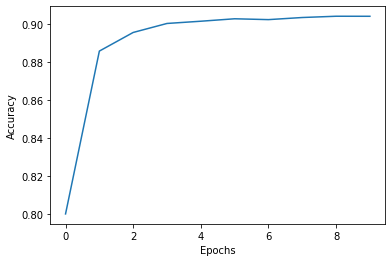

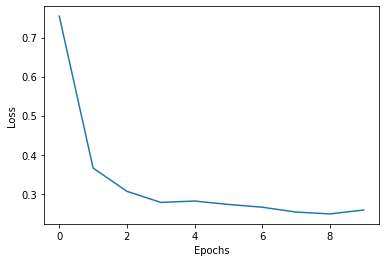

In [16]:
batches = split_list(X_train, batch_size)
batches_ind = split_list(range(len(X_train)), batch_size)
n_batches = len(batches)

accuracy_epoch = []
loss_epoch = []

N = len(X_train)
training_start_time = time.time()
for epoch in tqdm(range(n_epochs)):
    
    running_loss = 0.0
    print_every = 30 # N // 50
    print(n_batches)
    start_time = time.time()
    total_train_loss = 0
    total_output = torch.zeros(len(X_train),25)
    
    for ind in range(n_batches):
        
        batch_elements = [el for el in batches[ind]]
        batch_ind = [el for el in batches_ind[ind]]

#         input_data = torch.tensor(load_data(batch_elements))
        input_data = torch.tensor(batches[ind])
        
        input_data = Variable(input_data).transpose(2,3).transpose(1,2).to(device)
#         print(input_data.shape)
        labels = torch.from_numpy(y[batch_ind]).to(device)
        optimizer.zero_grad()

        # Forward pass, backward pass, optimize
        output = net(input_data)
        total_output[torch.tensor(batch_ind),:] = output.cpu().detach()
        loss_size = loss(output, labels.float())
        loss_size.backward()
        optimizer.step()   
        
        #Print statistics
        running_loss += loss_size.data.item()
        total_train_loss += loss_size.item()
        
        if ind % print_every == 0:
            print("Epoch {}, {:d}% \t train_loss: {:.4f} took: {:.4f}s".format(
                epoch + 1, int(100 * (ind + 1) / n_batches), running_loss / print_every, time.time() - start_time))
            # Reset running loss and time
            loss_epoch.append(running_loss)
            running_loss = 0.0
            start_time = time.time()
    train_acc = accuracy_score(y_train,(total_output>0.5).data.numpy())
    accuracy_epoch.append(train_acc)
    
    print("\n" + "Train Accuracy: {:.4f}".format(train_acc))    
    
plt.plot(range(n_epochs), accuracy_epoch)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
plt.plot(range(n_epochs), loss_epoch)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Test accuracy using CNN Model


Test Accuracy using CNN: 0.9036
Aleast one correct: 41.0%
All correct: 6.5


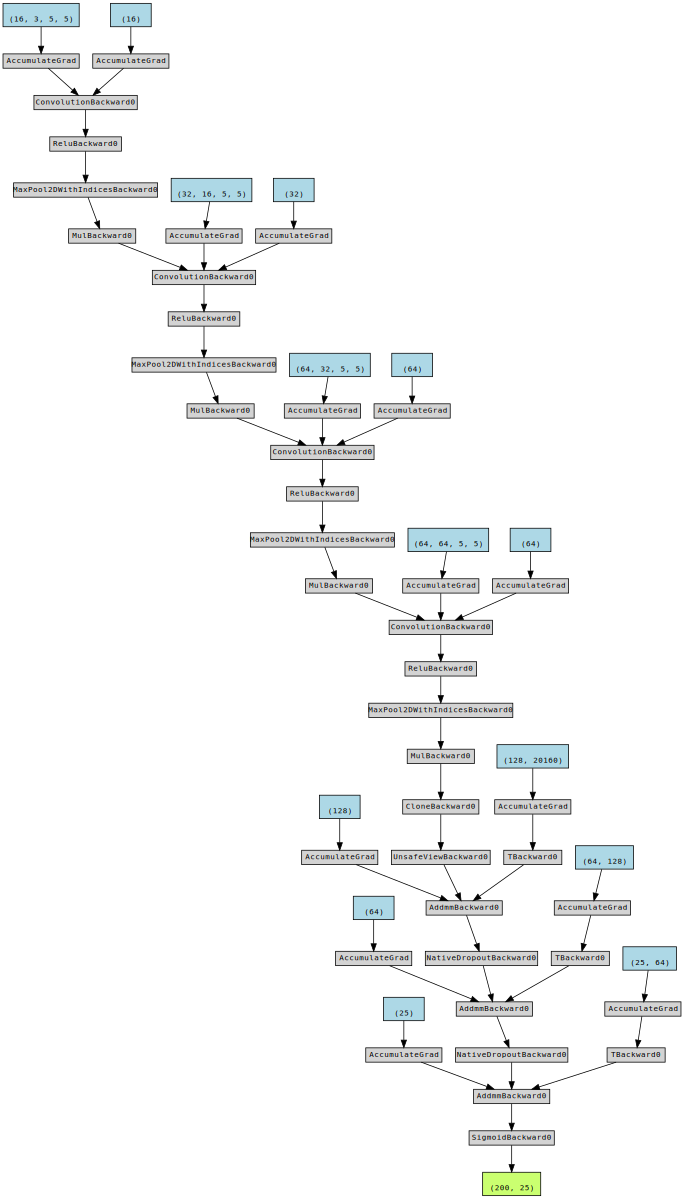

In [17]:
 #Test accuracy
test_data = torch.tensor(X_test)
test_data = Variable(test_data).transpose(2,3).transpose(1,2).to(device)
y_pred = (net(test_data).cpu().detach()>0.5).data.numpy()
test_acc = accuracy_score(y_test, y_pred)
print("\n" + "Test Accuracy using CNN: {:.4f}".format(test_acc)) 
print(f"Aleast one correct: {atleastOneMatch(y_test, y_pred)*100}%\nAll correct: {allMatch(y_test,y_pred)*100}")
make_dot(net(test_data))

# Applying the trained CNN model to Predict the Genre of the input image

In [18]:
def predict(cnn, location):
    img = image.load_img(location,target_size=(width,height,3))
    img = image.img_to_array(img)
    img = img/255

    img =  Variable(torch.from_numpy(img)).transpose(0,2).transpose(1,2).to(device)
    img = img.view(1,3,width,-1)
    proba = cnn(img)

    classes = np.array(dataset.columns[2:])
    proba = proba.cpu().detach().numpy()
    top_3 = np.argsort(proba[0])[:-4:-1]
    for i in range(3):
        print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))

Comedy (0.596)
Drama (0.421)
Action (0.279)


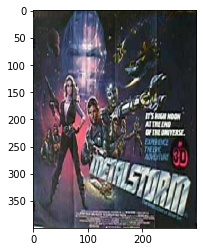

In [19]:
img = image.load_img('/kaggle/input/poster-archive/Multi_Label_dataset/Images/tt0085935.jpg',target_size=(width,height,3))
plt.imshow(img)
predict(net, '/kaggle/input/poster-archive/Multi_Label_dataset/Images/tt0085935.jpg')